In [2]:
import tensorflow as tf
import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard

!echo %CD%
!mkdir .\logs
!mkdir .\logs\lab-10-2-mnist_nn-tf2
!rmdir /q /s .\logs\lab-10-2-mnist_nn-tf2

log_dir = "./logs/lab-10-2-mnist_nn-tf2/"

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = log_dir + current_time + '/train'
test_log_dir = log_dir + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


C:\Users\greenblue\Work\study\machineLearning\DeepLearningZeroToAll


하위 디렉터리 또는 파일 .\logs이(가) 이미 있습니다.


Epoch: 0001, Cost: 150.303634644
Epoch: 0002, Cost: 38.867015839
Epoch: 0003, Cost: 24.159179688
Epoch: 0004, Cost: 16.759943008
Epoch: 0005, Cost: 12.093265533
Epoch: 0006, Cost: 9.052667618
Epoch: 0007, Cost: 6.703837395
Epoch: 0008, Cost: 5.103221416
Epoch: 0009, Cost: 3.893128395
Epoch: 0010, Cost: 2.884230852
Epoch: 0011, Cost: 2.159518003
Epoch: 0012, Cost: 1.651260972
Epoch: 0013, Cost: 1.273727417
Epoch: 0014, Cost: 0.963704109
Epoch: 0015, Cost: 0.804009557
Learning finished
Accuracy:  0.9414
Label:  [2]
Prediction:  [2]


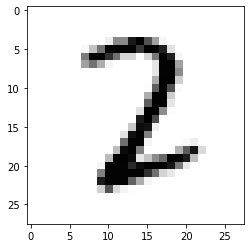

'\nEpoch: 0001 cost = 141.207671860\nEpoch: 0002 cost = 38.788445864\nEpoch: 0003 cost = 23.977515479\nEpoch: 0004 cost = 16.315132428\nEpoch: 0005 cost = 11.702554882\nEpoch: 0006 cost = 8.573139748\nEpoch: 0007 cost = 6.370995680\nEpoch: 0008 cost = 4.537178684\nEpoch: 0009 cost = 3.216900532\nEpoch: 0010 cost = 2.329708954\nEpoch: 0011 cost = 1.715552875\nEpoch: 0012 cost = 1.189857912\nEpoch: 0013 cost = 0.820965160\nEpoch: 0014 cost = 0.624131458\nEpoch: 0015 cost = 0.454633765\nLearning Finished!\nAccuracy: 0.9455\n'

In [5]:
# Lab 10 MNIST and NN
from functools import partial as bind
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
assert(tf.__version__.find('2') == 0)
tf.random.set_seed(777)  # for reproducibility

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = tf.reshape(x_train, [-1, 28*28])
x_train = tf.cast(x_train, tf.float32)
y_train = tf.one_hot(y_train, 10)
y_train = tf.cast(y_train, tf.float32)
x_train_len = len(x_train)
y_train_len = len(y_train)
# print(x_train_len, y_train_len)
# print(x_train, y_train)

x_test = tf.reshape(x_test, [-1, 28*28])
x_test = tf.cast(x_test, tf.float32)
y_test = tf.one_hot(y_test, 10)
x_test_len = len(x_test)
y_test_len = len(y_test)
# print(x_test_len, y_test_len)
# print(x_test, y_test)

learning_rate = 0.001
nb_classes = 10
batch_size = 100
training_epochs = 15
num_iterations = int(x_train_len / batch_size)

# weights & bias for nn layers
W1 = tf.Variable(tf.random.normal([784, 256]))
b1 = tf.Variable(tf.random.normal([256]))
L1 = lambda X: tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random.normal([256, 256]))
b2 = tf.Variable(tf.random.normal([256]))
L2 = lambda X: tf.nn.relu(tf.matmul(L1(X), W2) + b2)

W3 = tf.Variable(tf.random.normal([256, nb_classes]))
b3 = tf.Variable(tf.random.normal([nb_classes]))
hypothesis = lambda X: tf.matmul(L2(X), W3) + b3

# define cost/loss & optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def cost(X, Y):
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis(X),
                                                labels=Y)
    )

@tf.function
def correct_prediction(X, Y):
    return tf.equal(tf.argmax(hypothesis(X), axis=1), tf.argmax(Y, axis=1))

@tf.function
def accuracy(X, Y):
    return tf.reduce_mean(tf.cast(correct_prediction(X, Y), tf.float32))

# train my model
for epoch in range(training_epochs):
    avg_cost = 0

    for i in range(num_iterations):
        pos = i * batch_size
        batch_xs = x_train[pos: pos + batch_size, :]
        batch_ys = y_train[pos: pos + batch_size, :]
#         print(batch_xs)
#         print(batch_ys)
        
        cost_val = cost(batch_xs, batch_ys)
        avg_cost += cost_val / num_iterations

        # Minimize
        optimizer.minimize(bind(cost, batch_xs, batch_ys), var_list=[W1, b1, W2, b2, W3, b3])

        step = epoch * num_iterations + i
        if step % 100 == 0:
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', cost_val, step=step)
                tf.summary.scalar('accuracy', accuracy(batch_xs, batch_ys), step=step)
        
    tf.print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

tf.print("Learning finished")

# Test model and check accuracy
tf.print(
    "Accuracy: ",
    accuracy(x_test, y_test)
)

# Get one and predict
r = random.randint(0, y_test_len - 1)
tf.print(
    "Label: ", tf.argmax(y_test[r : r + 1], 1)
)
tf.print(
    "Prediction: ",
    tf.argmax(hypothesis(x_test[r : r + 1]), 1),
)

plt.imshow(
    tf.reshape(x_test[r : r + 1], [28, 28]),
    cmap="Greys",
    interpolation="nearest",
)
plt.show()

'''
Epoch: 0001 cost = 141.207671860
Epoch: 0002 cost = 38.788445864
Epoch: 0003 cost = 23.977515479
Epoch: 0004 cost = 16.315132428
Epoch: 0005 cost = 11.702554882
Epoch: 0006 cost = 8.573139748
Epoch: 0007 cost = 6.370995680
Epoch: 0008 cost = 4.537178684
Epoch: 0009 cost = 3.216900532
Epoch: 0010 cost = 2.329708954
Epoch: 0011 cost = 1.715552875
Epoch: 0012 cost = 1.189857912
Epoch: 0013 cost = 0.820965160
Epoch: 0014 cost = 0.624131458
Epoch: 0015 cost = 0.454633765
Learning Finished!
Accuracy: 0.9455
'''


In [6]:
#!taskkill /im tensorboard.exe /F
%tensorboard --logdir logs --host "0.0.0.0" --port 6006

Reusing TensorBoard on port 6006 (pid 23120), started 11:15:36 ago. (Use '!kill 23120' to kill it.)